In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customers-dataset/Customers.csv


In [2]:
import seaborn as sns

#For data viz
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Linear regression model
from sklearn.linear_model import LinearRegression

Goal: Find the demographic with the highest probability of having a high (>70) spending score. This allows a (hyopthetical) company/store to target their top spender audiences more heavily.

Read the file in
Take a peak at the df to see its format

In [3]:
file_path = '/kaggle/input/customers-dataset/Customers.csv'
df = pd.read_csv(file_path)
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


Create dataframes for splitting training and testing data after some data viz

In [4]:
X = df.drop(columns=['CustomerID'])
X = X.drop(columns=['Spending Score (1-100)'])
y = df['Spending Score (1-100)']

Initial thoughts on data and what is needed to create model for prediction:

1) Gender, age, annual income, profession, family size distributions and their correlations to spending score

2) Work experience and annual income are likely to be highly correlated, but should still confirm. If not, then add 'Work Experience' to (1)

Going to use linear regression to predict spending score

Do a quick check on the dataframe to see what data types, and values are missing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


We note that all features are full, except for 'Profession' feature, where 35 values are null

Quick function call to confirm null values

In [6]:
df.isnull().sum()

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

Time to start the data visualization/analysis to prepare the data for the model.

In [7]:
le = LabelEncoder()
X['Gender'] = le.fit_transform(X['Gender'])
X['Profession'] = le.fit_transform(X['Profession'])
X.corr()

,Gender,Age,Annual Income ($),Profession,Work Experience,Family Size
Gender,1.000000,0.005821,0.004701,0.008862,0.020651,0.000228
Age,0.005821,1.000000,0.021378,-0.022848,-0.014319,0.038254
Annual Income ($),0.004701,0.021378,1.000000,0.020446,0.089136,0.093005
Profession,0.008862,-0.022848,0.020446,1.000000,-0.002378,0.046138
Work Experience,0.020651,-0.014319,0.089136,-0.002378,1.000000,0.011873
Family Size,0.000228,0.038254,0.093005,0.046138,0.011873,1.000000


Fairly low correlations among all features.

The female percentage of the population is 59.3% and the male percentage is 40.7%


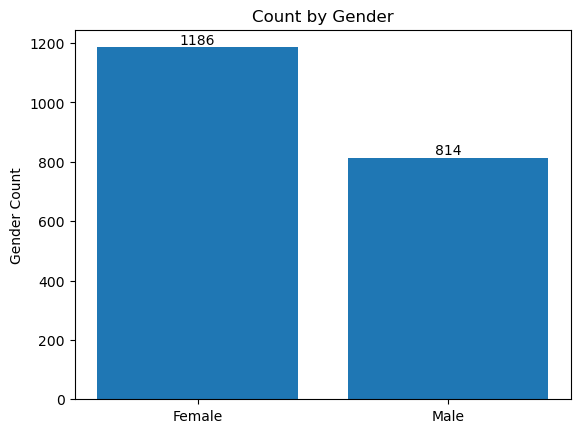

In [8]:
gender = ['Female', 'Male']
gender_count = df['Gender'].value_counts()
fig, axes = plt.subplots()
bar_axes = axes.bar(gender, gender_count)
axes.set(ylabel='Gender Count', title='Count by Gender')
axes.bar_label(bar_axes)

female_pct = 1186/2000
male_pct = 814/2000

print(f"The female percentage of the population is {female_pct*100}% and the male percentage is {male_pct*100:.1f}%")

In [9]:
df['Age'].describe()

count    2000.000000
mean       48.960000
std        28.429747
min         0.000000
25%        25.000000
50%        48.000000
75%        73.000000
max        99.000000
Name: Age, dtype: float64

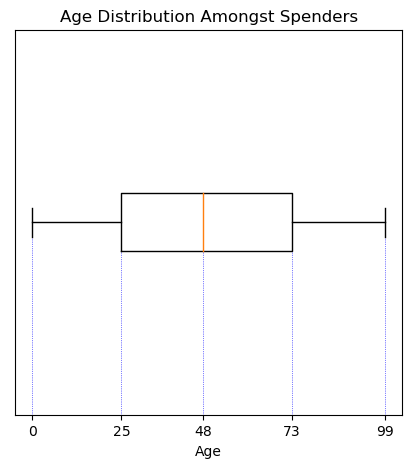

In [10]:
age_fig = plt.figure(figsize = (5,5))
quantiles = np.quantile(df['Age'], [0, 0.25, 0.5, 0.75, 1])
plt.boxplot(df['Age'], vert=False)
plt.title("Age Distribution Amongst Spenders")
plt.xlabel('Age')
plt.yticks([0],[])

plt.vlines(quantiles, [0]*quantiles.size, [1]*quantiles.size, color='b', linestyles='dotted', lw=.5, zorder=0)
plt.ylim(0.5,1.5)
plt.xticks(quantiles)
plt.show()

In [11]:
df['Annual Income ($)'].describe()

count      2000.000000
mean     110731.821500
std       45739.536688
min           0.000000
25%       74572.000000
50%      110045.000000
75%      149092.750000
max      189974.000000
Name: Annual Income ($), dtype: float64

In [12]:
df['Annual Income ($)'].describe()

count      2000.000000
mean     110731.821500
std       45739.536688
min           0.000000
25%       74572.000000
50%      110045.000000
75%      149092.750000
max      189974.000000
Name: Annual Income ($), dtype: float64

Text(0, 0.5, 'Count')

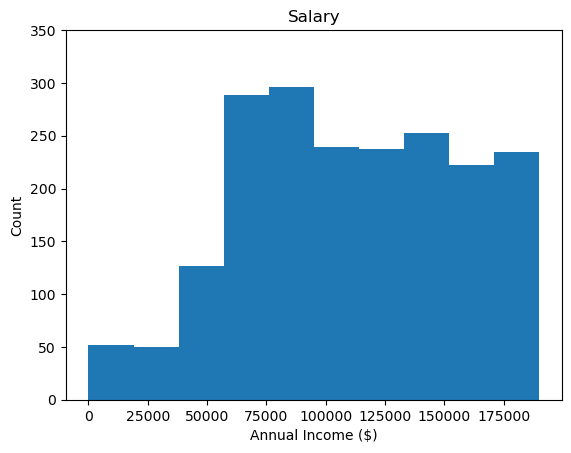

In [13]:
plt.hist(df['Annual Income ($)'])
plt.ylim(0, 350)
plt.title("Salary")
plt.xlabel("Annual Income ($)")
plt.ylabel("Count")

It looks like this store has mostly high earners shopping here. Distribution is heavy after 62 500.

In [14]:
profession_count = df['Profession'].value_counts()
counts = profession_count.tolist()
professions = profession_count.index
professions = professions.tolist()
professions_dict = {}
for i, profession in enumerate(professions):
    professions_dict[profession] = counts[i]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Artist'),
  Text(1, 0, 'Healthcare'),
  Text(2, 0, 'Entertainment'),
  Text(3, 0, 'Engineer'),
  Text(4, 0, 'Doctor'),
  Text(5, 0, 'Executive'),
  Text(6, 0, 'Lawyer'),
  Text(7, 0, 'Marketing'),
  Text(8, 0, 'Homemaker')])

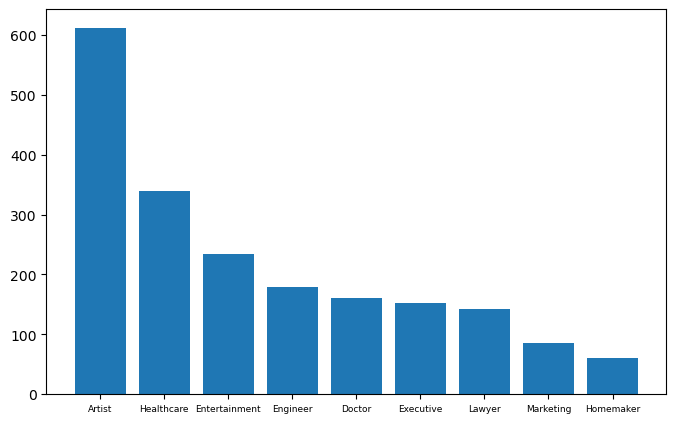

In [15]:
figure(figsize=(8,5))
plt.bar(range(len(professions)), professions_dict.values(), tick_label=list(professions_dict.keys()))
plt.xticks(fontsize=6.5)